In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy.stats import beta
from scipy.stats import gamma
sns.set_style("whitegrid")
import math

# Gamma Distribution

#### Alpha parameter variation with beta constant

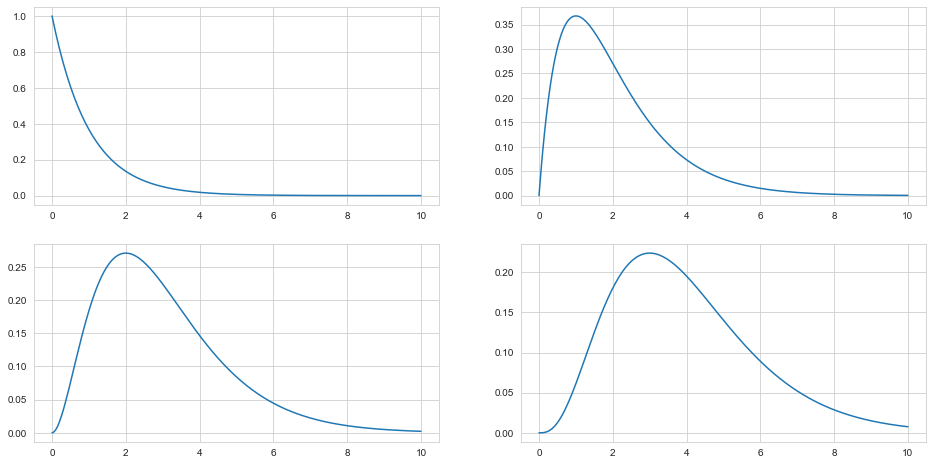

In [43]:
x = np.linspace (0, 10, 200)
fig,ax= plt.subplots(2,2,figsize=(16,8))

y1 = gamma.pdf(x, a=1, scale=1)
ax[0,0].plot(x,y1)
y1 = gamma.pdf(x, a=2, scale=1)
ax[0,1].plot(x,y1)
y1 = gamma.pdf(x, a=3, scale=1)
ax[1,0].plot(x,y1)
y1 = gamma.pdf(x, a=4, scale=1)
ax[1,1].plot(x,y1)

#### Beta parameter variation with alpha constant

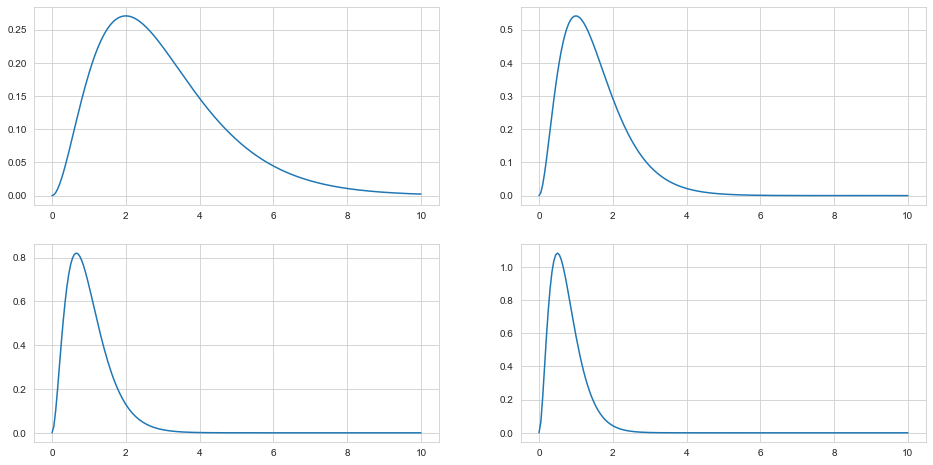

In [44]:
fig,ax= plt.subplots(2,2,figsize=(16,8))

y1 = gamma.pdf(x, a=3, scale=1)
ax[0,0].plot(x,y1)
y1 = gamma.pdf(x, a=3, scale=0.5)
ax[0,1].plot(x,y1)
y1 = gamma.pdf(x, a=3, scale=0.33)
ax[1,0].plot(x,y1)
y1 = gamma.pdf(x, a=3, scale=0.25)
ax[1,1].plot(x,y1)

In [45]:
class Environment:
    def __init__(self,variants,payouts,n_trials,variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts+np.random.normal(0,0.04,size=len(variants)),0,0.2)
        else:
            self.payouts = payouts
        self.n_trials=n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k,self.n_trials)
    def run(self,agent):
        for i in range(self.n_trials):
            x_choosen = agent.choose_k()
            reward = np.random.binomial(1,p=self.payouts[int(x_choosen)])
            agent.reward = reward
            agent.update()
            self.total_reward +=reward
        agent.collectdata()
        return self.total_reward

            

In [46]:
class BaseSampler:
    def __init__(self,env,n_samples=None,n_learning=None,e=0.05):
        self.env=env
        self.shape=(env.n_k,n_samples)
        self.variants=env.variants
        self.payouts=env.payouts
        self.n_trials = env.n_trials
        self.ad_i=np.zeros(env.n_trials)
        self.r_i=np.zeros(env.n_trials)
        self.thetas=np.zeros(self.n_trials)
        self.regret_i=np.zeros(env.n_trials)
        self.thetaregret=np.zeros(env.n_trials)
        
        self.a=np.ones(env.n_k)
        self.b=np.ones(env.n_k)
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k=0
        self.i=0
        self.n_samples=n_samples
        self.n_learning=n_learning
        self.e=e
        self.ep=np.random.uniform(0,1,size=env.n_trials)
        self.exploit=(1-e)
        
    def collectdata(self):
        self.data = pd.DataFrame(dict(ad=self.ad_i,reward=self.r_i,regret = self.regret_i))
        

In [47]:
class RandomSampler(BaseSampler):
    def __init__(self,env):
        super().__init__(env)
    def choose_k(self):
        self.k=np.random.choice(self.variants)
        return self.k
    def update(self):
        self.thetaregret[self.i]=np.max(self.theta)-self.theta[self.k]
        self.a[self.k]+=self.reward
        self.b[self.k]+=1
        self.theta=self.a/self.b
        self.ad_i[self.i]=self.k
        self.r_i[self.i]=self.reward
        self.i+=1
        

In [48]:
class eGreedy(BaseSampler):
    def __init__(self,env,n_learning,e):
        super().__init__(env,n_learning,e)
    def choose_k(self):
        if(self.i<self.n_learning):
            self.k =np.random.choice(self.variants)
        else:
            self.k = np.argmax(self.theta)
        if(self.ep[self.i]>self.exploit):
            self.k=np.random.choice(self.variants)
        else:
            self.k=self.k
        return self.k
    def update(self):
        self.a[self.k]+=self.reward
        self.b[self.k]+=1
        self.theta= self.a/self.b
        self.thetas[self.i]=self.theta[self.k]
        self.thetaregret[self.i]=np.max(self.thetas) - self.theta[self.k]
        self.ad_i[self.i]=self.k
        self.r_i[self.i]=self.reward
        self.i+=1

In [49]:
class UCB(BaseSampler):
    def __init__(self,env):
        super().__init__(env)
        self.d=len(self.env.variants)
        self.numbers_of_selections = np.zeros(self.d)
        self.sums_of_reward = np.zeros(self.d)
        self.reward=0
    def choose_k(self):
        ad = 0
        max_upper_bound = 0
        for j in range(0, self.d):
            
            if (self.numbers_of_selections[j] > 0):
                average_reward = self.sums_of_reward[j] / self.numbers_of_selections[j]
#                 print(self.sums_of_reward)
                delta_i = math.sqrt(2 * math.log(self.i+1) / self.numbers_of_selections[j])
                upper_bound = average_reward + delta_i
#                 print(upper_bound)
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                self.k = j
#                 print(j)
#                 return self.k
            
        return self.k
    def update(self):
        self.numbers_of_selections[self.k]+=1
        self.sums_of_reward[self.k]+=self.reward
        self.a[self.k]+=self.reward
        self.b[self.k]+=1
        self.theta= self.a/self.b
        self.thetas[self.i]=self.theta[self.k]
        self.thetaregret[self.i]=np.max(self.thetas) - self.theta[self.k]
        self.ad_i[self.i]=self.k
        self.r_i[self.i]=self.reward
        self.i+=1

In [50]:
class ThompsonSampler(BaseSampler):
    def __init__(self,env):
        super().__init__(env)
    
    def choose_k(self):
        self.theta =np.random.beta(self.a,self.b)
        self.k=self.variants[np.argmax(self.theta)]
        return self.k
    def update(self):
        self.a[self.k]+=self.reward
        self.b[self.k]+=1-self.reward
        self.thetas[self.i]=self.theta[self.k]
        self.thetaregret[self.i]=np.max(self.thetas) - self.theta[self.k]
        self.ad_i[self.i]=self.k
        self.r_i[self.i]=self.reward
        self.i+=1

In [51]:
n_trials = 10000
machines = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
payouts = [0.023, 0.03, 0.029, 0.001, 0.05, 0.06, 0.0234, 0.035, 0.01, 0.11]
labels = ["V" + str(i) + (str(p)) for i, p in zip(machines, payouts)]
labels

['V00.023',
 'V10.03',
 'V20.029',
 'V30.001',
 'V40.05',
 'V50.06',
 'V60.0234',
 'V70.035',
 'V80.01',
 'V90.11']

## Random Sampler A/B Test

In [52]:
en0 = Environment(machines, payouts, n_trials)
rs = RandomSampler(env=en0)
en0.run(agent=rs)

366

## UCB

In [53]:
en3 = Environment(machines, payouts, n_trials)
ucb = UCB(env=en3)
en3.run(agent=ucb)

525

## E-Greedy

In [54]:
en1 = Environment(machines, payouts, n_trials)
eg = eGreedy(env=en1, n_learning=500, e=0.1)
en1.run(agent=eg)

970

## Thompson Sampler

In [55]:
en2 = Environment(machines, payouts, n_trials)
tsa = ThompsonSampler(env=en2)
en2.run(agent=tsa)

1056

In [56]:
n_tests = 100
minscoreeg=100000
maxscoreeg=0
minscorets=1000000
maxscorets=0
rs_scoress = np.zeros(n_tests)
egreedy_scores = np.zeros(n_tests)
ts_scores = np.zeros(n_tests)

for i in range(n_tests):
    en0 = Environment(machines, payouts, n_trials)
    rs = RandomSampler(env=en0)
    rs_scoress[i] = en0.run(agent=rs)
    
    
    en1 = Environment(machines, payouts, n_trials)
    eg = eGreedy(env=en1, n_learning=1000, e=0.1)
    egreedy_scores[i] = en1.run(agent=eg)
    if(minscoreeg>egreedy_scores[i]):
        minscoreeg=egreedy_scores[i]
    if(maxscoreeg<egreedy_scores[i]):
        maxscoreeg=egreedy_scores[i]
    
    en2 = Environment(machines, payouts, n_trials)
    tsa = ThompsonSampler(env=en2)
    ts_scores[i] = en2.run(agent=tsa)
    if(minscorets>ts_scores[i]):
        minscorets=ts_scores[i]
    if(maxscorets<ts_scores[i]):
        maxscorets=ts_scores[i]

In [57]:
print(minscoreeg , maxscoreeg)
print(minscorets,maxscorets)

469.0 1119.0
916.0 1117.0


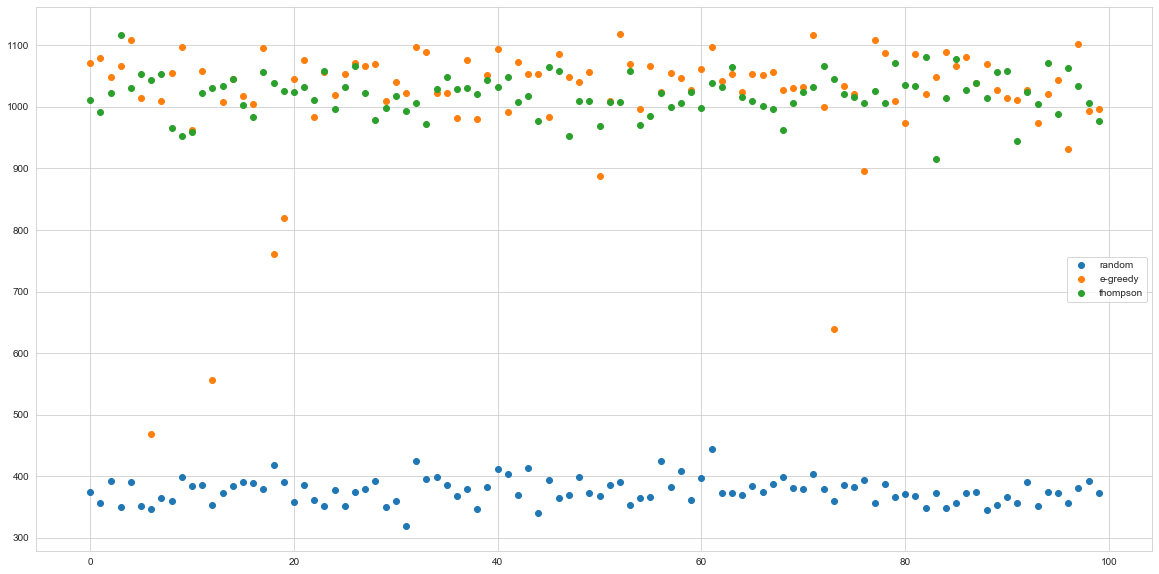

In [58]:
plt.figure(figsize=(20,10))
x = np.arange(0, 100)
plt.scatter(x,rs_scoress, label="random");
plt.scatter(x,egreedy_scores, label="e-greedy")
plt.scatter(x,ts_scores, label="thompson");
plt.legend();

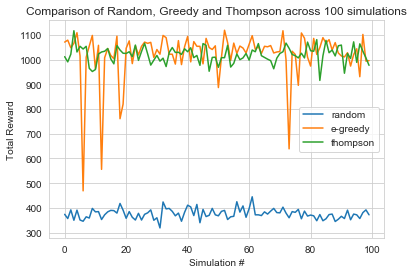

In [59]:
plt.plot(rs_scoress, label="random");
plt.plot(egreedy_scores, label="e-greedy")
plt.plot(ts_scores, label="thompson");
plt.xlabel("Simulation #")
plt.ylabel("Total Reward");
plt.title("Comparison of Random, Greedy and Thompson across 100 simulations")
plt.legend();
# plt.savefig("simualtion_100.jpg")
plt.show()

In [60]:
print(egreedy_scores.mean())
print(ts_scores.mean())

1020.3
1020.05


In [61]:
s=pd.Series(rs.ad_i)

In [62]:
h=s.value_counts()

In [63]:
type(h)

pandas.core.series.Series

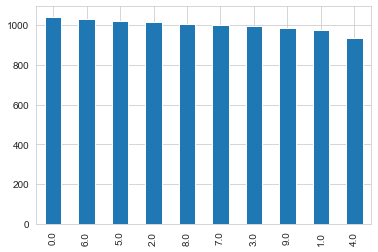

In [64]:
h.plot.bar()

In [65]:
def plot_k_choices(agent, env, title):
#     plt.figure(figsize=(20,8))
    x = np.arange(0, agent.n_trials)
    s=pd.Series(agent.ad_i)
    h=s.value_counts()
    print(h)
    h.plot.bar()
#     plt.hist(myhist.index,myhist.value)
#     plt.scatter(x, agent.ad_i, c=agent.ad_i, marker=".", alpha=1)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Trial", fontsize=16, fontweight="bold")
    plt.ylabel("Variant", fontsize=16, fontweight="bold")
#     plt.yticks(list(range(10)))
#     plt.colorbar();

9.0    2464
5.0    1397
4.0    1254
7.0     837
2.0     791
1.0     715
0.0     696
6.0     686
8.0     585
3.0     575
dtype: int64


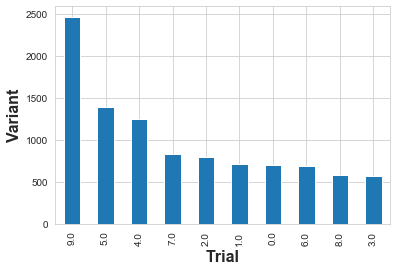

In [66]:
plot_k_choices(ucb, en3, "")

0.0    1041
6.0    1031
5.0    1020
2.0    1013
8.0    1007
7.0    1000
3.0     993
9.0     986
1.0     975
4.0     934
dtype: int64


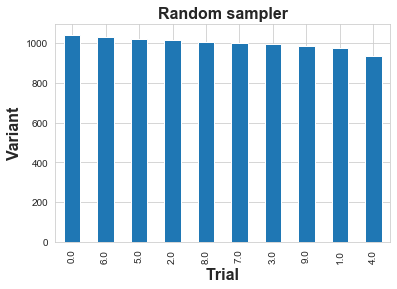

In [67]:
plot_k_choices(rs, en0, "Random sampler")

9.0    8139
5.0    1173
1.0     118
4.0     111
3.0      95
7.0      90
8.0      71
6.0      70
0.0      68
2.0      65
dtype: int64


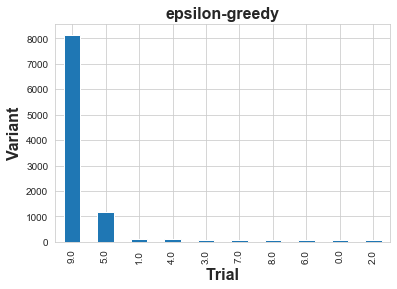

In [68]:
plot_k_choices(eg, en1,"epsilon-greedy")

9.0    8700
5.0     399
2.0     185
0.0     134
1.0     126
4.0     125
6.0     101
8.0     101
3.0      65
7.0      64
dtype: int64


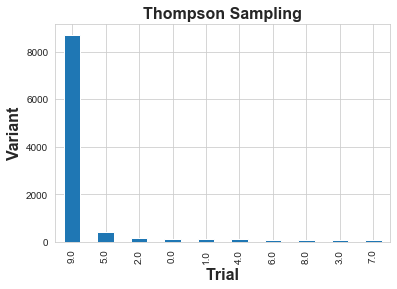

In [69]:
plot_k_choices(tsa, en2,"Thompson Sampling")

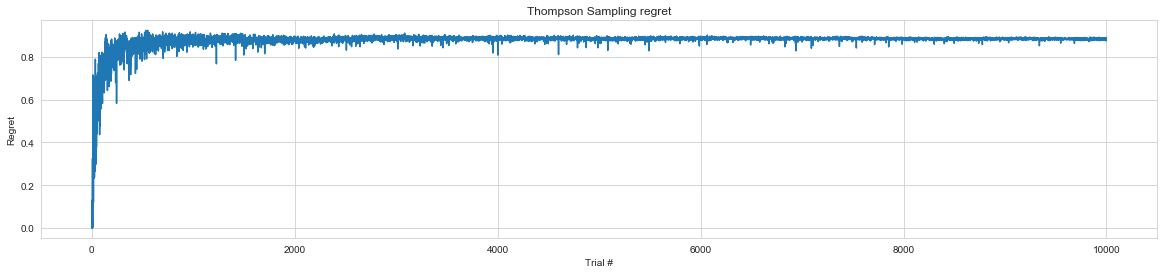

In [70]:
plt.figure(figsize=(20,4))
plt.plot(tsa.thetaregret)
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Thompson Sampling regret");

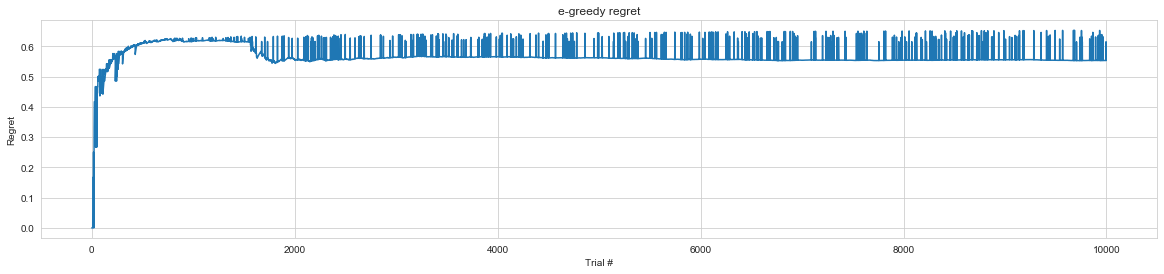

In [71]:
plt.figure(figsize=(20,4))
plt.plot(eg.thetaregret)
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("e-greedy regret");

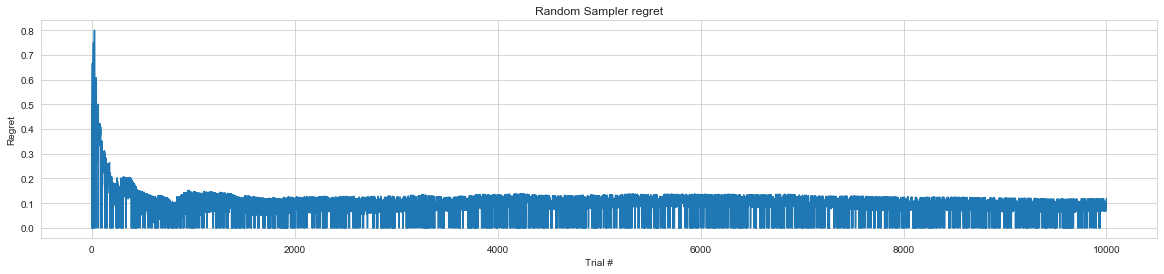

In [72]:
plt.figure(figsize=(20,4))
plt.plot(rs.thetaregret)
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Random Sampler regret");

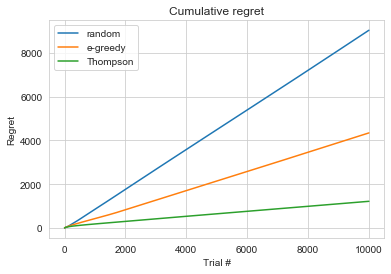

In [73]:
plt.plot(np.cumsum(1 - rs.thetaregret), label="random")
plt.plot(np.cumsum(1 - eg.thetaregret), label="e-greedy")
plt.plot(np.cumsum(1 - tsa.thetaregret), label="Thompson")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Cumulative regret")
plt.legend();

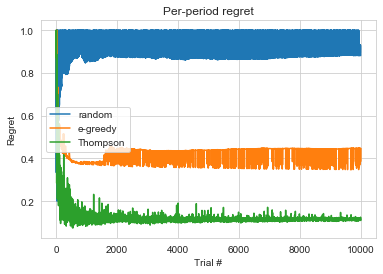

In [74]:
plt.plot(1 - rs.thetaregret, label="random")
plt.plot(1 - eg.thetaregret, label="e-greedy")
plt.plot(1 - tsa.thetaregret, label="Thompson")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Per-period regret")
plt.legend();


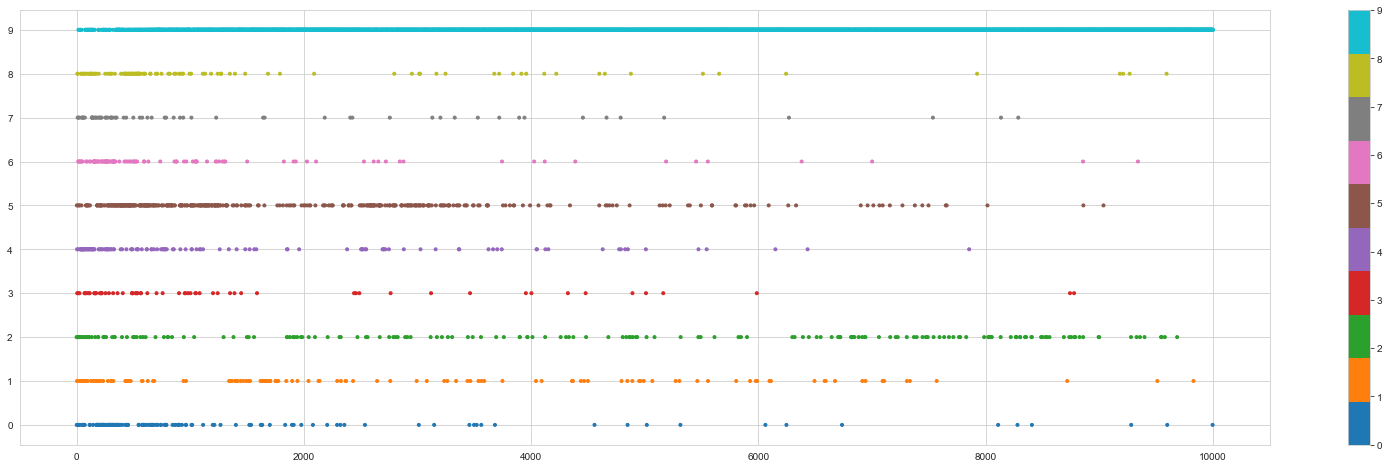

In [75]:
plt.figure(figsize=(28,8))
xd = np.arange(0, eg.n_trials)
cmap = plt.cm.get_cmap("tab10", 10)
plt.scatter(xd, tsa.ad_i, cmap=cmap, c=tsa.ad_i, marker=".", alpha=1)
plt.yticks(list(range(10)))
plt.colorbar();

In [76]:
x = np.arange(0, .2, 0.0001)
cmap = list(plt.cm.tab10(list(range(len(machines)))))

# plt.figure(figsize=(26, 14))

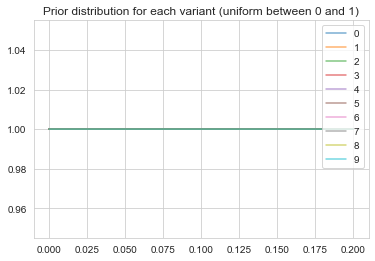

In [77]:
n_rounds = 0
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
# plt.subplot(231)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
#     print(pdf)
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Prior distribution for each variant (uniform between 0 and 1)")
plt.legend();

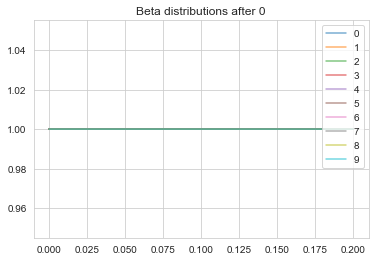

In [78]:
rounds = 500
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
# plt.subplot(232)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
#     print(pdf)
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();

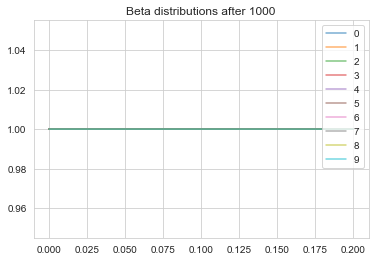

In [79]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 1000
# plt.subplot(233)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();


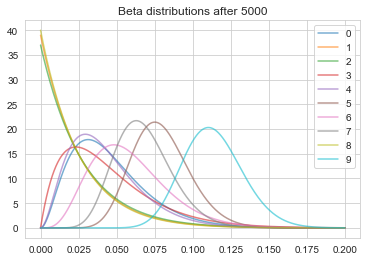

In [80]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 5000
# plt.subplot(234)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();

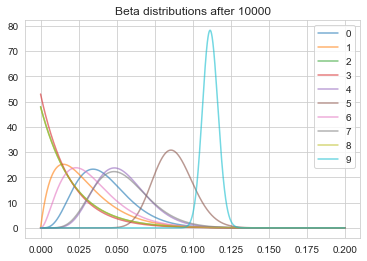

In [81]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 10000
# plt.subplot(235)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();

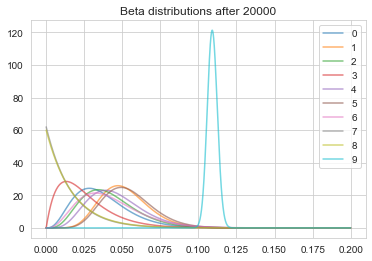

In [82]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 20000
# plt.subplot(236)

for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();

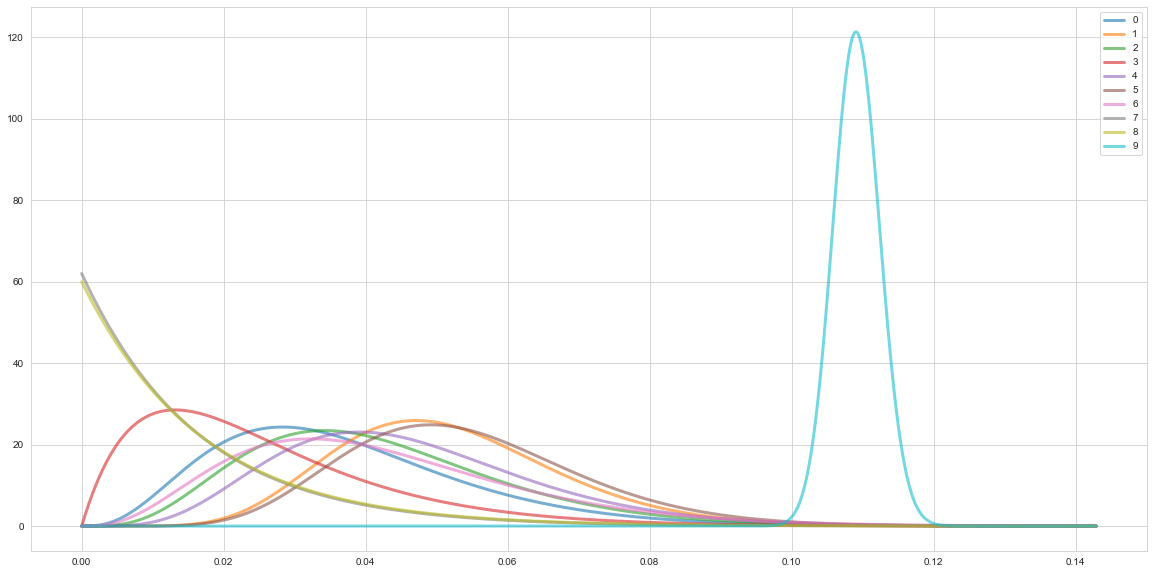

In [83]:
plt.figure(figsize=(20,10))
cmapi = iter(plt.cm.tab10(list(range(len(machines)))))
x = np.arange(0, max(tsa.theta) + 0.03, 0.0001)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = next(cmapi)
    plt.plot(x, pdf, c=c, label=i, linewidth=3, alpha=.6)
plt.legend();